# Predição da situação final de deputados federais nas eleições de 2014

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados foram eleitos nas eleições de 2014. De forma específica:

1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)
2. Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
3. Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
4. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)
5. Envie seus melhores modelos (a saída deles) à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)
    - Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).

    - Experimente outras estratégias de ensembles (e.g. Stacking).

    - Experimente balancear as classes,  caso estejam desbalanceadas.

Os dados estão neste link: https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data (Links para um site externo)Links para um site externo

Para a entrega envie o link no GitHub com o notebook usado para resolver o Lab.

Obs: Vocês estarão competindo com os alunos de graduação da disciplina Ciência de Dados Preditiva, que estarão trabalhando nesta mesma atividade.

In [155]:
import pandas as pd
import numpy as np
import matplotlib
import imblearn
import csv
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score,precision_recall_fscore_support

from imblearn.combine import SMOTETomek

## 1. Análise dos dados 

In [156]:
train_data = pd.read_csv("data/train2006a2010.csv")
test_data = pd.read_csv("data/test2014part.csv")

# load the dataset as a pandas data frame
df_train_data = pd.DataFrame(train_data)
df_test_data = pd.DataFrame(test_data)

frames = [df_train_data, df_test_data]
df_data = pd.concat(frames)

# Fixing index by number of rows
print(df_data.shape)
df_data = df_data.reset_index(drop = True)
df_data.head()

(12214, 24)


/home/veruska/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


,ano,cargo,estado_civil,grau,media_despesa,media_receita,nome,ocupacao,partido,quantidade_despesas,...,recursos_de_partido_politico,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,sequencial_candidato,sexo,situacao,total_despesa,total_receita,uf
0,2006,DEPUTADO FEDERAL,CASADO(A),ENSINO MÉDIO COMPLETO,1184.54,2766.67,JOSÉ LUIZ NOGUEIRA DE SOUSA,VEREADOR,PT,14,...,0.0,9000.0,6300.00,1300.0,10001,MASCULINO,nao_eleito,16583.60,16600.00,AP
1,2006,DEPUTADO FEDERAL,SOLTEIRO(A),SUPERIOR COMPLETO,846.92,1755.85,LOIVA DE OLIVEIRA,SERVIDOR PÚBLICO ESTADUAL,PT,24,...,0.0,15000.0,1000.00,201.0,10002,FEMININO,nao_eleito,20325.99,22826.00,RO
2,2006,DEPUTADO FEDERAL,VIÚVO(A),SUPERIOR COMPLETO,1187.09,9301.22,MARIA DALVA DE SOUZA FIGUEIREDO,PEDAGOGO,PT,123,...,0.0,34150.0,62220.80,59500.0,10002,FEMININO,eleito,146011.70,158120.80,AP
3,2006,DEPUTADO FEDERAL,CASADO(A),ENSINO MÉDIO INCOMPLETO,375.14,500.19,ROMALDO MILANI,MILITAR REFORMADO,PRONA,8,...,0.0,1150.0,1101.12,750.0,10002,MASCULINO,nao_eleito,3001.12,3001.12,MS
4,2006,DEPUTADO FEDERAL,CASADO(A),ENSINO FUNDAMENTAL COMPLETO,875.31,2496.25,ANSELMO DE JESUS ABREU,DEPUTADO,PT,133,...,0.0,50878.0,0.00,68942.0,10003,MASCULINO,eleito,116416.64,119820.00,RO


In [157]:
print(df_train_data.shape)
df_train_data.head()

(7622, 24)


,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,situacao
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.67,0.0,...,14,14,16583.60,1184.54,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,nao_eleito
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.85,6625.0,...,24,23,20325.99,846.92,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,nao_eleito
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,158120.80,9301.22,2250.0,...,123,108,146011.70,1187.09,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,eleito
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.19,0.0,...,8,8,3001.12,375.14,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,nao_eleito
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,119820.00,2496.25,0.0,...,133,120,116416.64,875.31,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,eleito


In [158]:
print(df_test_data.shape)
df_test_data.head()

(4592, 23)


,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,...,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao
0,2014,10000000135,EMERSON DA SILVA SANTOS,AC,PSOL,3,3,1580.00,526.67,0.00,...,80.0,3,3,1580.00,526.67,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,SOLTEIRO(A),"CORRETOR DE IMÓVEIS, SEGUROS, TÍTULOS E VALORES"
1,2014,10000000142,GERALDO SILVA DOS SANTOS,AC,PSOL,5,5,3180.00,636.00,0.00,...,80.0,6,5,3130.02,521.67,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),VIGILANTE
2,2014,10000000158,CARLOS CESAR CORREIA DE MESSIAS,AC,PSB,40,38,336793.13,8419.83,1923.07,...,0.0,145,139,326869.78,2254.27,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,CASADO(A),OUTROS
3,2014,10000000161,IDESIO LUIS FRANKE,AC,PT,29,29,156719.32,5404.11,39122.32,...,25000.0,136,121,241016.07,1772.18,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),AGRÔNOMO
4,2014,10000000163,LEONARDO CUNHA DE BRITO,AC,PT,160,146,737073.00,4606.71,10000.00,...,25000.0,518,354,567401.15,1095.37,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),ADVOGADO


Todos os dados de treinamento estão rotulados.

In [159]:
df_data[df_data.situacao.isnull()].shape

(4592, 24)

### Processamento dos dados

- Remoção de variáveis não relevantes.
- Tratamento das features numéricas com valores ausentes (NaN's);
- Transformação das variáveis categóricas.

#### Remoção de variáveis

Optou-se por excluir a variável **nome**, porque ela não influencia na quantidade de votos e possui muitos valores categóricos, e **cargo**, porque só apresenta um valor. Foram também excluídas **media_receita** e **media_despesa**, porque estas variáveis são derivações de outras 2 colunas.

In [160]:
print(df_data.shape)

#removing collumns
df_data = df_data.drop(['nome', 'cargo', 'media_receita', 'media_despesa'], 1)

print(df_data.shape)

(12214, 24)
(12214, 20)


#### Checando variáveis com valores NaN

In [161]:
df_data.isnull().any()

ano                                      False
estado_civil                             False
grau                                     False
ocupacao                                 False
partido                                  False
quantidade_despesas                      False
quantidade_doacoes                       False
quantidade_doadores                      False
quantidade_fornecedores                  False
recursos_de_outros_candidatos.comites    False
recursos_de_partido_politico             False
recursos_de_pessoas_fisicas              False
recursos_de_pessoas_juridicas            False
recursos_proprios                        False
sequencial_candidato                     False
sexo                                     False
situacao                                  True
total_despesa                            False
total_receita                            False
uf                                       False
dtype: bool

A única variável com valores nulos é **situação**, que, neste caso, são os valores referentes aos dados de teste. Portanto, não os preencheremos, porque mais adiante separaremos o conjunto em dados de traino/validação e teste.

#### Transformação das variáveis categóricas

As variáveis categóricas presentes nos dados, como **ocupação** e **estado_civil**, serão transformadas em variáveis numéricas, a fim de permitir a sua utilização nos modelos de regressão logo a seguir.

In [162]:
df_data['situacao'] = df_data['situacao'].map({'eleito': 1, 'nao_eleito': 0})

df_data = pd.get_dummies(df_data)

print(df_data.shape)
df_data.head()

(12214, 262)


,ano,quantidade_despesas,quantidade_doacoes,quantidade_doadores,quantidade_fornecedores,recursos_de_outros_candidatos.comites,recursos_de_partido_politico,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,...,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO
0,2006,14,6,6,14,0.0,0.0,9000.0,6300.00,1300.0,...,0,0,0,0,0,0,0,0,0,0
1,2006,24,13,13,23,6625.0,0.0,15000.0,1000.00,201.0,...,0,0,0,1,0,0,0,0,0,0
2,2006,123,17,16,108,2250.0,0.0,34150.0,62220.80,59500.0,...,0,0,0,0,0,0,0,0,0,0
3,2006,8,6,6,8,0.0,0.0,1150.0,1101.12,750.0,...,0,0,0,0,0,0,0,0,0,0
4,2006,133,48,48,120,0.0,0.0,50878.0,0.00,68942.0,...,0,0,0,1,0,0,0,0,0,0


Separando os dados de teste.

In [163]:
test = df_data.loc[7622:,]
X_test = test.drop('situacao', axis = 1)

data = df_data.loc[:7621, ]
y = data['situacao']
X = data.drop("situacao", axis = 1)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2)

In [164]:
print(X_train.shape)
print(X_validation.shape)

(6097, 261)
(1525, 261)


### Balanceamento dos dados

Abaixo, vemos a distribuição dos dados por situação: vereadores eleitos e vereadores não-eleitos.

In [165]:
target_count = y_train.value_counts()
print('Class não-eleito:', target_count[0])
print('Class eleito:', target_count[1])
print('Proporção:', round(target_count[0] / target_count[1], 2), ': 1')

('Class n\xc3\xa3o-eleito:', 5266)
('Class eleito:', 831)
('Propor\xc3\xa7\xc3\xa3o:', 6.0, ': 1')


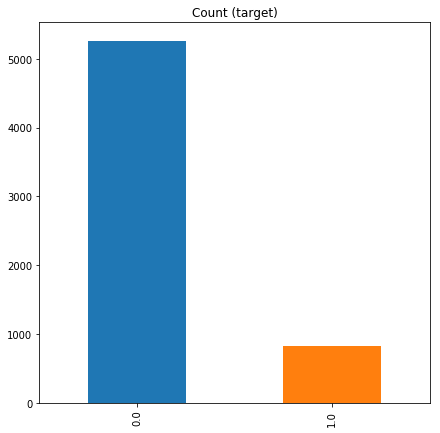

In [166]:
target_count.plot(kind = 'bar', title = 'Count (target)')

No conjunto de dados, 86,5% dos vereadores analisados não foram eleitos e apenas 13,5% foram eleitos, apresentando um alto desbalanceamento. Para cada vereador eleito, há aproximadamente 6 vereadores não-eleitos. O ideal seria um conjunto de dados com metade dos vereadores eleitos e a outra metado não-eleitos.

Com este desbalanceamento, o classificador irá especializar-se nos dados cuja classe é majoritária (vereadores não-eleitos) e, portanto, a cada novo dado, ele terá mais probabilidade de classificar como não-eleito. Outro problema surge ao usar a acurácia para avaliar a qualidade do modelo, porque ela vai ser elevada, porém não significará qualidade no contexto de dados desbalanceados.

Uma alternativa para contornar esse desbalanceamento é usar reamostragem, por exemplo, que consiste em remover amostras da classe majoritária (subamostragem) e/ou adicionar mais exemplos da classe minoritária (sobre-amostragem).

### Amostragem

Usaremos subamostragem com as técnicas SMOTE + Tomek para balancear os dados, que é uma combinação de sobre-amostragem e subamostragem, respectivamente.

SMOTE (Synthetic Minority Oversampling TEchnique) consiste em sintetizar elementos para a classe minoritária, com base naqueles que já existem. Ele trabalha aleatoriamente escolhendo um ponto da classe minoritária e calculando os k vizinhos mais próximos para este ponto. Os pontos sintéticos são adicionados entre o ponto escolhido e seus vizinhos, como ilustrado na imagem abaixo.

![image.png](smote.png)

Tomek links são pares de instâncias muito próximas, mas de classes opostas. Remover as instâncias da classe majoritária de cada par aumenta o espaço entre as duas classes, facilitando o processo de classificação.

![image.png](tomeklinks.png)

Portanto, a combinação dessas duas técnicas cria dados sintéticos na classe minoritária e separa mellhor as classes, ao remover o dado da classe majoritária na fronteira de separação, ou seja, nos Tomek links.

In [167]:
smt = SMOTETomek(ratio='auto')
X_train_sampled, y_train_sampled = smt.fit_sample(X_train, y_train)

Abaixo, vemos que agora as classes possuem a mesma quantidade de dados, ou seja, estão balanceadas e não prejudicarão os modelos a serem treinados.

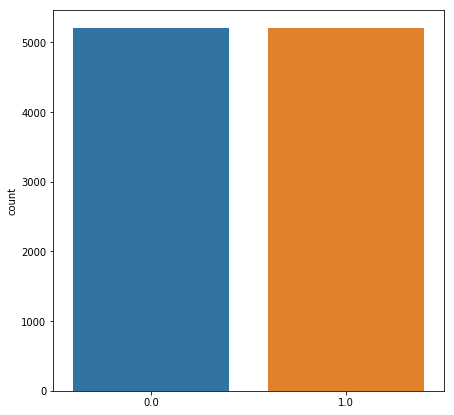

In [168]:
y_train_sampled_counted = y_train_sampled[:,np.newaxis]
sns.countplot(y_train_sampled_counted[:,0])

## 2. Implementação dos modelos

In [169]:
CROSS_VALIDATION_GENERATOR = 20

Separando os dados em treino e validação.

Funções auxiliares

In [170]:
# function to train the model and to calculate the f1 with cross validation
def f1_cv(model):
    f1 = cross_val_score(model, X_train_sampled, y_train_sampled, scoring = "f1", cv = CROSS_VALIDATION_GENERATOR)
    return(f1)

In [209]:
def get_metrics_train(model):
    acc = cross_val_score(model, X_train_sampled, y_train_sampled.round(), cv = CROSS_VALIDATION_GENERATOR)
    prec = cross_val_score(model, X_train_sampled, y_train_sampled, scoring = 'precision', cv = CROSS_VALIDATION_GENERATOR)
    rec = cross_val_score(model, X_train_sampled, y_train_sampled, scoring = 'recall', cv = CROSS_VALIDATION_GENERATOR)
    f1 = cross_val_score(model, X_train_sampled, y_train_sampled, scoring = 'f1', cv = CROSS_VALIDATION_GENERATOR)
    roc_auc = cross_val_score(model, X_train_sampled, y_train_sampled, scoring = 'roc_auc', cv = CROSS_VALIDATION_GENERATOR)
    
    print('Training:')
    print("Accuracy: %.2f%%" % (np.ma.median(acc) * 100))
    print("Precision: %.2f%%" % (np.ma.median(prec) * 100))
    print("Recall: %.2f%% " % (np.ma.median(rec) * 100))
    print("F-measure: %.2f%%" % (np.ma.median(f1) * 100))
    print("ROC AUC: %.2f%%" % (np.ma.median(roc_auc) * 100))
    print('-------------------')

In [217]:
def get_metrics_validation(model):
    y_pred = model.predict(X_validation)
    
    acc = accuracy_score(y_validation, y_pred)
    prec, rec, f1, t  = precision_recall_fscore_support(y_validation, y_pred, average = 'binary')
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_validation, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    score = model.score(X_validation, y_validation)
    
    print('Validation:')
    print("Accuracy: %.2f%%" % (acc * 100))
    print("Precision: %.2f%%" % (prec * 100))
    print("Recall: %.2f%% " % (rec * 100))
    print("F-measure: %.2f%%" % (f1 * 100))
    print("Score: %.2f%%" % (score * 100))
    print("ROC AUC: %.2f%%" % (roc_auc * 100))
    
    return [acc, prec, rec, f1, roc_auc, score]

In [173]:
# function to plot the f1 vs parameter value
def plot_f1_param(series, param_name):
    series.plot(title = "F-measure vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("F-measure")

In [174]:
# function to get the best F1 and the best parameter value of the model
def best_f1_param(series):
    best_f1 = series.max()
    best_param = series.idxmax() 
    
    return(best_f1, best_param)

In [175]:
# function to train the model and to return the score
def train_model(model, print_coef):
    model.fit(X_train_sampled, y_train_sampled)
    if (print_coef):
        print_coefficients(model)
    
    score = model.score(X_validation, y_validation)
    return score

In [176]:
# function to plot the residual vs predictions values of the model
def plot_res_vs_pred(model):
    y_pred = model.predict(X_validation)
    res = y_validation - y_pred
    
    matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)
    plt.plot(y_pred, res, 'k.', color='blue')
    plt.axhline(y = 0., color = 'r', linestyle = '-')
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")

In [177]:
def get_params_values(min_value, max_value):
    param_list = list(range(min_value, max_value))

    # subsetting just the odd ones
    params = list(filter(lambda x: x % 2 != 0, param_list))
    return params

In [179]:
def generate_output(model, name):
    y_pred = model.predict(X_test)
    
    test_predict_df = pd.DataFrame()
    test_predict_df['Id'] = X_test.sequencial_candidato
    test_predict_df['Predicted'] = y_pred
    
    test_predict_df['Predicted'] = test_predict_df['Predicted'].map({1: 'eleito', 0: 'nao_eleito'})
    print(test_predict_df.head())
    
    test_predict_df.to_csv('data/output-' + name + '.csv', index = False, quoting = csv.QUOTE_ALL)

### Regressão Logística

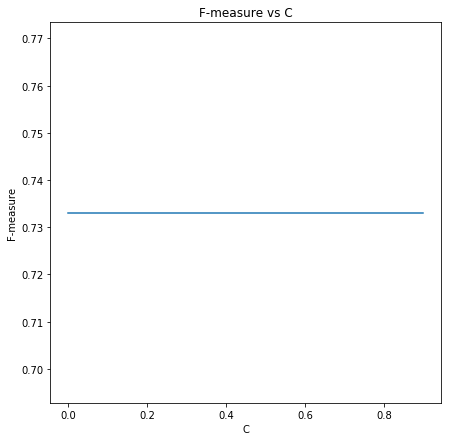

In [180]:
# creating odd list of C for
cs = [0.0001, 0.001, 0.005, 0.1, 0.5, 0.9]

cv_logisticRegression_f1 = [f1_cv(LogisticRegression(C = c)).mean() 
            for c in cs]

series_logisticRegression = pd.Series(cv_logisticRegression_f1, index = cs)
plot_f1_param(series_logisticRegression, "C")

In [181]:
best_f1_logisticRegression, best_param_logisticRegression = best_f1_param(series_logisticRegression)

model_logisticRegression = LogisticRegression(C = best_param_logisticRegression)
score_logisticRegression = train_model(model_logisticRegression, False)

print("Modelo Regressão Logística, com os dados de 2006 e 2010: \nC = {0} \nF-measure = {1} \nScore = {2}").format(best_param_logisticRegression, best_f1_logisticRegression, score_logisticRegression)

Modelo Regressão Logística, com os dados de 2006 e 2010: 
C = 0.0001 
F-measure = 0.73311059332 
Score = 0.550819672131


In [218]:
get_metrics_train(model_logisticRegression)

acc_logReg, prec_logReg, rec_logReg, f1_logReg, roc_auc_logReg, score_logReg = get_metrics_validation(model_logisticRegression)

Training:
Accuracy: 69.04%
Precision: 64.17%
Recall: 88.27% 
F-measure: 74.26%
ROC AUC: 89.56%
-------------------
Validation:
Accuracy: 55.08%
Precision: 19.30%
Recall: 78.97% 
F-measure: 31.02%
Score: 55.08%
ROC AUC: 65.28%


In [185]:
generate_output(model_logisticRegression, 'logisticRegression')

               Id   Predicted
7622  10000000135  nao_eleito
7623  10000000142  nao_eleito
7624  10000000158      eleito
7625  10000000161      eleito
7626  10000000163      eleito


### KNN

O modelo de regressão k-NN é baseado nos k vizinhos mais próximos, ou seja, o valor alvo é classificado pela interpolação local dos valores alvos associados aos vizinhos mais próximos no conjunto de treinamento. Portanto, o melhor valor de k deve ser encontrado para o nosso conjunto de dados.

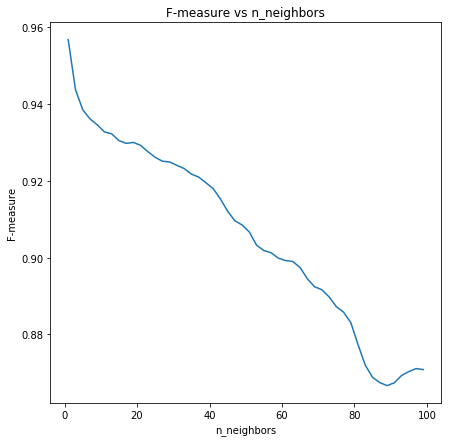

In [186]:
# creating odd list of K for KNN
neighbors = get_params_values(1, 50)

cv_knn_f1 = [f1_cv(KNeighborsClassifier(n_neighbors = n)).mean() 
            for n in neighbors]

series_knn = pd.Series(cv_knn_f1, index = neighbors)
plot_f1_param(series_knn, "n_neighbors")

In [187]:
best_f1_knn, best_param_knn = best_f1_param(series_knn)

model_knn = KNeighborsClassifier(n_neighbors = best_param_knn)
score_knn = train_model(model_knn, False)

print("Modelo K-NN, com os dados de 2006 e 2010: \nNeighbors = {0} \nF-score = {1} \nScore = {2}").format(best_param_knn, best_f1_knn, score_knn)

Modelo K-NN, com os dados de 2006 e 2010: 
Neighbors = 1 
F-score = 0.956793492805 
Score = 0.887868852459


In [219]:
get_metrics_train(model_knn)

acc_knn, prec_knn, rec_knn, f1_knn, roc_auc_knn, score_knn = get_metrics_validation(model_knn)

Training:
Accuracy: 95.58%
Precision: 92.31%
Recall: 99.42% 
F-measure: 95.74%
ROC AUC: 95.58%
-------------------
Validation:
Accuracy: 88.79%
Precision: 54.72%
Recall: 71.28% 
F-measure: 61.92%
Score: 88.79%
ROC AUC: 81.32%


### Árvore de Decisão

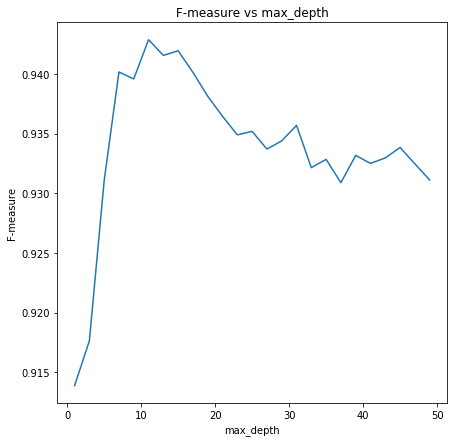

In [190]:
max_depth = get_params_values(1, 50)

cv_dt_f1 = [f1_cv(DecisionTreeClassifier(max_depth = d)).mean() 
            for d in max_depth]

series_dt = pd.Series(cv_dt_f1, index = max_depth)
plot_f1_param(series_dt, "max_depth")

In [191]:
best_f1_dt, best_param_dt = best_f1_param(series_knn)

model_dt = DecisionTreeClassifier(max_depth = best_param_dt)
score_dt = train_model(model_dt, False)

print("Modelo Decision Tree, com os dados de 2006 e 2010: \nMax depth = {0} \nF-score = {1} \nScore = {2}").format(best_param_dt, best_f1_dt, score_dt)

Modelo Decision Tree, com os dados de 2006 e 2010: 
Max depth = 1 
F-score = 0.956793492805 
Score = 0.874098360656


In [220]:
get_metrics_train(model_dt)

acc_dt, prec_dt, rec_dt, f1_dt, roc_auc_dt, score_dt = get_metrics_validation(model_dt)

Training:
Accuracy: 90.87%
Precision: 87.04%
Recall: 95.59% 
F-measure: 91.42%
ROC AUC: 90.87%
-------------------
Validation:
Accuracy: 87.41%
Precision: 50.40%
Recall: 96.41% 
F-measure: 66.20%
Score: 87.41%
ROC AUC: 91.25%


### AdaBoost

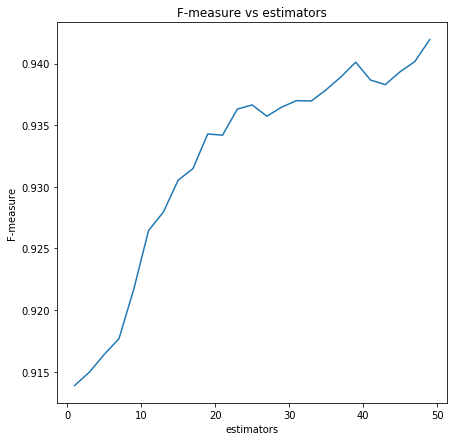

In [194]:
estimators = get_params_values(1, 50)

cv_ada_f1 = [f1_cv(AdaBoostClassifier(n_estimators = n)).mean() 
            for n in estimators]

series_ada = pd.Series(cv_ada_f1, index = estimators)
plot_f1_param(series_ada, "estimators")

In [195]:
best_f1_ada, best_param_ada = best_f1_param(series_ada)

model_ada = AdaBoostClassifier(n_estimators = best_param_ada)
score_ada = train_model(model_ada, False)

print("Modelo AdaBoost, com os dados de 2006 e 2010: \nEstimators = {0} \nF-score = {1} \nScore = {2}").format(best_param_ada, best_f1_ada, score_ada)

Modelo AdaBoost, com os dados de 2006 e 2010: 
Estimators = 49 
F-score = 0.941946985538 
Score = 0.911475409836


In [221]:
get_metrics_train(model_ada)

acc_ada, prec_ada, rec_ada, f1_ada, roc_auc_ada, score_ada = get_metrics_validation(model_ada)

Training:
Accuracy: 95.77%
Precision: 93.13%
Recall: 98.85% 
F-measure: 95.90%
ROC AUC: 99.55%
-------------------
Validation:
Accuracy: 91.15%
Precision: 61.72%
Recall: 81.03% 
F-measure: 70.07%
Score: 91.15%
ROC AUC: 86.83%


In [198]:
generate_output(model_ada, 'adaBoost')

               Id   Predicted
7622  10000000135  nao_eleito
7623  10000000142  nao_eleito
7624  10000000158      eleito
7625  10000000161      eleito
7626  10000000163      eleito


### Random Forest

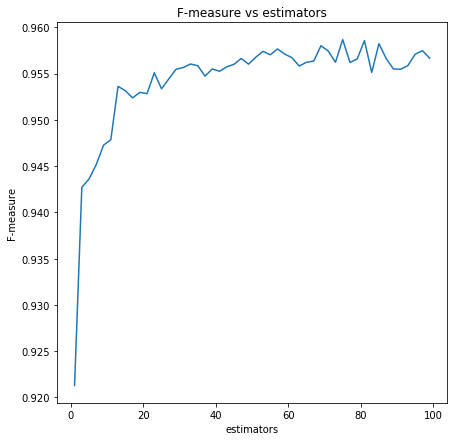

In [199]:
estimators = get_params_values(1, 100)

cv_rf_f1 = [f1_cv(RandomForestClassifier(n_estimators = n)).mean() 
            for n in estimators]

series_rf = pd.Series(cv_rf_f1, index = estimators)
plot_f1_param(series_rf, "estimators")

In [200]:
best_f1_rf, best_param_rf= best_f1_param(series_rf)

model_rf = RandomForestClassifier(n_estimators = best_param_rf)
score_rf = train_model(model_rf, False)

print("Modelo Random Forest, com os dados de 2006 e 2010: \nEstimators = {0} \nF-score = {1} \nScore = {2}").format(best_param_rf, best_f1_rf, score_rf)

Modelo Random Forest, com os dados de 2006 e 2010: 
Estimators = 75 
F-score = 0.95866872093 
Score = 0.928524590164


In [222]:
get_metrics_train(model_rf)

acc_rf, prec_rf, rec_rf, f1_rf, roc_auc_rf, score_rf = get_metrics_validation(model_rf)

Training:
Accuracy: 96.54%
Precision: 93.64%
Recall: 100.00% 
F-measure: 96.47%
ROC AUC: 99.82%
-------------------
Validation:
Accuracy: 92.85%
Precision: 68.22%
Recall: 82.56% 
F-measure: 74.71%
Score: 92.85%
ROC AUC: 88.46%


In [239]:
generate_output(model_rf, 'randomForest')

               Id   Predicted
7622  10000000135  nao_eleito
7623  10000000142  nao_eleito
7624  10000000158      eleito
7625  10000000161      eleito
7626  10000000163      eleito


## Resultados

Ao analisar as métricas Acurácia, Precisão, Recall, F-measure e AUC no treino e na validação, percebemos que elas sempre são menores na validação, ou seja, ao tentar classificar dados ainda não vistos. Os valores maiores na validação ocorrem porque os modelos vão adaptando-se aos dados e, portanto, produzindo menos erros.

Abaixo, vemos essas métricas aplicadas na validação de cada modelo de classificação.

In [223]:
col_names = ['model', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'score']

acc_logReg, prec_logReg, rec_logReg, f1_logReg, roc_auc_logReg, score_logReg

values = [['Regressão Logística', acc_logReg, prec_logReg, rec_logReg, f1_logReg, roc_auc_logReg, score_logReg],
          ['KNN', acc_knn, prec_knn, rec_knn, f1_knn, roc_auc_knn, score_knn],
          ['Árvore de Decisão', acc_dt, prec_dt, rec_dt, f1_dt, roc_auc_dt, score_dt],
          ['AdaBoost', acc_ada, prec_ada, rec_ada, f1_ada, roc_auc_ada, score_ada],
          ['Random Forest', acc_rf, prec_rf, rec_rf, f1_rf, roc_auc_rf, score_rf]]

models_metrics_df = pd.DataFrame(values, columns = col_names)

models_metrics_df

,model,accuracy,precision,recall,f1,auc,score
0,Regressão Logística,0.550820,0.192982,0.789744,0.310171,0.652767,0.550820
1,KNN,0.887869,0.547244,0.712821,0.619154,0.813177,0.887869
2,Árvore de Decisão,0.874098,0.504021,0.964103,0.661972,0.912502,0.874098
3,AdaBoost,0.911475,0.617188,0.810256,0.700665,0.868286,0.911475
4,Random Forest,0.928525,0.682203,0.825641,0.747100,0.884625,0.928525


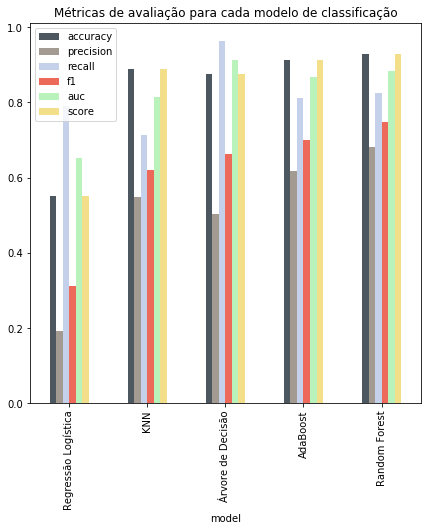

In [238]:
my_colors = ['#4C5760', '#A39A92', '#C5D1EB', '#ED6A5A', '#BAF2BB', '#F3DE8A']

models_metrics_df.plot(x = 'model', kind = 'bar', title = u'Métricas de avaliação para cada modelo de classificação',
                      color = my_colors)

Em geral, a Regressão Logística teve o pior desempenho, enquanto que o Random Forest foi o melhor modelo, cujas predições nos dados de teste foram submetidas na competição do [Kaggle](https://www.kaggle.com/c/ufcg-cdp-20182-lab3).

## Referências

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

https://beckernick.github.io/oversampling-modeling/